In [3]:
%matplotlib inline

import torch
import os
import shutil
import random 
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt 

In [4]:
torch.manual_seed(0)
print ('pytorch version', torch.__version__)

pytorch version 1.10.2


In [5]:
#preparing Training & test sets
#https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
class_names = ['normal','viral','covid']
root_dir = '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset'
source_dirs = ['Normal','Viral Pneumonia','COVID']


if os.path.isdir(os.path.join(root_dir,source_dirs[1])):
    os.mkdir(os.path.join(root_dir,'test'))

    for i,d in enumerate(source_dirs):
        print(os.path.join(root_dir,d))
        print(os.path.join(root_dir,class_names[i]))
        os.rename(os.path.join(root_dir,d),os.path.join(root_dir,class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir,'test',c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir,c)) if x.lower().endswith('png')]
        selected_images = random.sample(images,30)
        for image in selected_images:
            source_path = os.path.join(root_dir,c,image)
            target_path = os.path.join(root_dir,'test',c,image)
            shutil.move(source_path,target_path)
        

In [70]:
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self,image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal','viral','covid']

        for c in class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform

    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name],image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)





In [71]:
#image trasnformations
train_transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224,224)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485,0.0456,0.406],std=[0.229,0.224,0.225])
                        ])

test_transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224,224)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485,0.0456,0.406],std=[0.229,0.224,0.225])
                        ])                        

In [73]:
train_dirs = {
'normal': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/normal',
'viral': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/viral',
'covid':'/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/covid'

}

train_dataset = ChestXrayDataset(train_dirs,train_transform)


test_dirs = {
'normal': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/normal',
'viral': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/viral',
'covid':'/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/covid'

}

test_dataset = ChestXrayDataset(test_dirs,test_transform)

found 10162 normal examples
found 1315 viral examples
found 3586 covid examples
found 30 normal examples
found 30 viral examples
found 30 covid examples


In [74]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)


In [75]:

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 2511
Num of test batches 15


In [79]:
for X,y in dl_test:
    print("Shape of X [N, C, H, W] : ", X.shape)
    print("Shape of y : ", y.shape,y.dtype)
    break

Shape of X [N, C, H, W] :  torch.Size([6, 3, 224, 224])
Shape of y :  torch.Size([6]) torch.int64


In [76]:
#data visualization

class_names = train_dataset.class_names

def show_images(images,labels,preds):
    plt.figure(figsize=(8,4))
    for i,image in enumerate(images):
        plt.subplot(1,6,i+1,xticks=[],yticks=[])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485,0.0456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std+mean
        image = np.clip(image,0,1)
        plt.imshow(image)

        col = 'green' if preds[i] ==labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color = col)

    plt.tight_layout()
    plt.show()

    

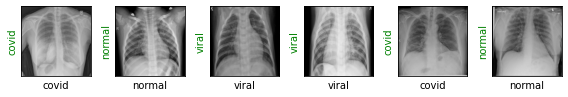

In [78]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

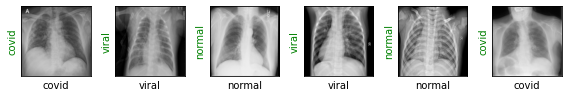

In [80]:
images,labels = next(iter(dl_test))
show_images(images,labels,labels)

In [81]:
#transfer learning

resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sureshgorakala/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
resnet18.fc = torch.nn.Linear(in_features=512,out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(),lr=3e-5)

In [85]:
def show_preds():
    resnet18.eval()
    images.labels = next(iter(dl_test))
    outputs = resnet18(images)
    _,preds = torch.max(outputs,1)
    show_images(images,labels,labels)

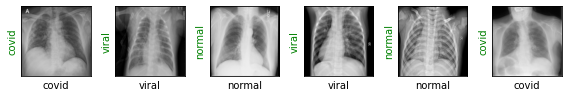

In [86]:
show_preds()

In [91]:
def train(epochs):
    print('starting training....')
    for e in range(0,epochs):
        print('='*20)
        print(f'starting epoch {e+1}/{epochs}')
        print('='*20)


        train_loss = 0
        resnet18.train()

        for train_step,(images,labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss +=loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step',train_step)
                acc=0
                val_loss = 0
                resnet18.eval()

                for val_step,(images,labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs,labels)
                    val_loss +=loss.item()


                    _,preds = torch.max(outputs,1)
                    acc+=sum(preds==labels).numpy()

                val_loss /= (val_step+1)
                acc = acc/len(test_dataset)

                print(f'val loss: {val_loss:.4f},Acc: {acc:.4f}')
                show_preds()

                resnet18.train()

                if acc>0.95:
                    print('performance cond satisfied')
                    return 


    train_loss /= (train_step+1)                
    print(f'training loss: {train_loss:.4f}')




starting training....
starting epoch 1/2
Evaluating at step 0
val loss: 1.2163,Acc: 0.1667


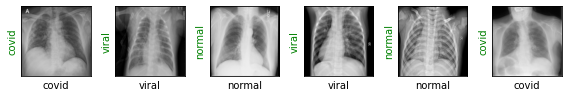

Evaluating at step 20
val loss: 0.6580,Acc: 0.7222


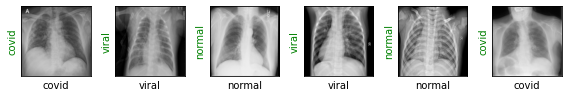

Evaluating at step 40
val loss: 0.4055,Acc: 0.8556


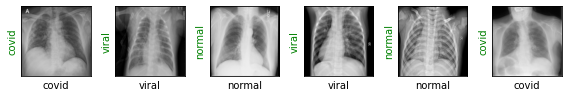

Evaluating at step 60
val loss: 0.3199,Acc: 0.9000


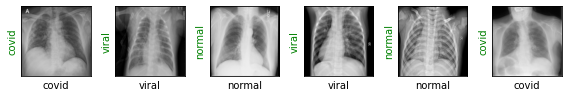

Evaluating at step 80
val loss: 0.2919,Acc: 0.9000


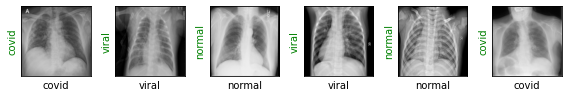

Evaluating at step 100
val loss: 0.3390,Acc: 0.8556


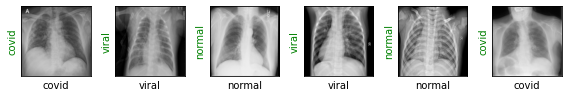

Evaluating at step 120
val loss: 0.2891,Acc: 0.8667


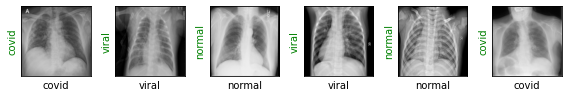

Evaluating at step 140
val loss: 0.2928,Acc: 0.8889


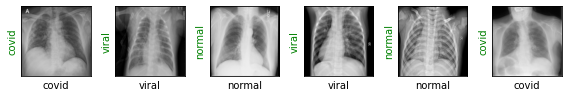

Evaluating at step 160
val loss: 0.2868,Acc: 0.8778


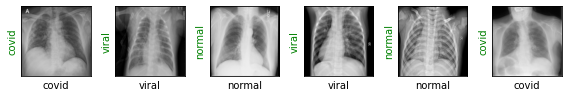

Evaluating at step 180
val loss: 0.2397,Acc: 0.8778


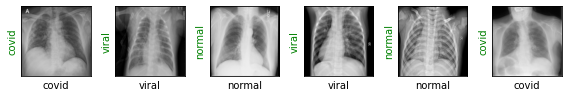

Evaluating at step 200
val loss: 0.2516,Acc: 0.8889


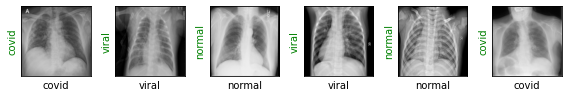

Evaluating at step 220
val loss: 0.2416,Acc: 0.9222


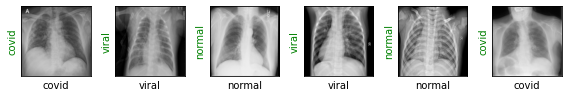

Evaluating at step 240
val loss: 0.2032,Acc: 0.9000


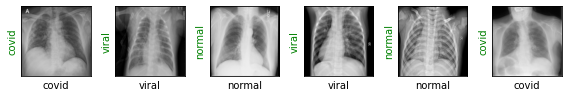

Evaluating at step 260
val loss: 0.1655,Acc: 0.9444


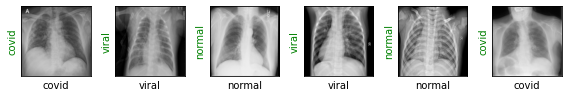

Evaluating at step 280
val loss: 0.0866,Acc: 0.9778


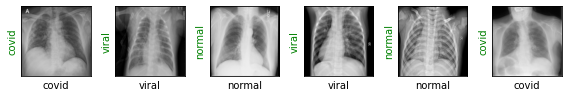

performance cond satisfied


In [92]:
train(epochs=2)